<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 9.7 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)


train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction

In [13]:
from  pyod.models.deep_svdd import DeepSVDD
start = timeit.default_timer()
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=128, hidden_neurons=[64, 32])
model.fit(train_scale)
end = timeit.default_timer()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                3264      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

In [14]:
print(f"Total training time {end-start} s")

Total training time 775.198150892 s


In [15]:
print(model.model_)

In [16]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data

start = timeit.default_timer()
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test
end = timeit.default_timer()

In [17]:
print(f'Total prediction time {end-start} s')

Total prediction time 17.133434029 s


In [18]:
pd.DataFrame(test_scores).describe()

0
count  4.499190e+05
mean   3.038993e+03
std    1.077884e+04
min    2.409555e-08
25%    2.494025e-02
50%    7.179011e-01
75%    2.282599e+00
max    4.268845e+04

In [19]:
pd.DataFrame(train_scores).describe()

0
count  475200.000000
mean        0.024009
std         0.003422
min         0.000003
25%         0.022900
50%         0.023706
75%         0.024929
max         0.995271

In [20]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

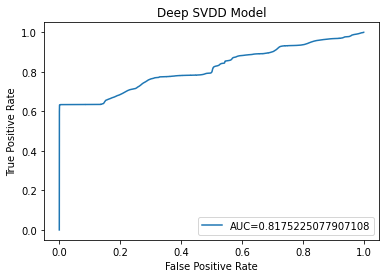

In [21]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Deep SVDD Model')
plt.legend(loc=4)
plt.show()

In [22]:
np.any(np.isnan(test_scores)),np.all(np.isfinite(test_scores))

(False, True)

In [23]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [24]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [25]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_train['type'] = 'train'
df_error_test = pd.DataFrame(norm_test,columns = ['error'])
df_error_test['type'] = 'test'

pd.concat([df_error_train,df_error_test]).to_csv("/content/drive/MyDrive/Data_sci_Project/error.csv")

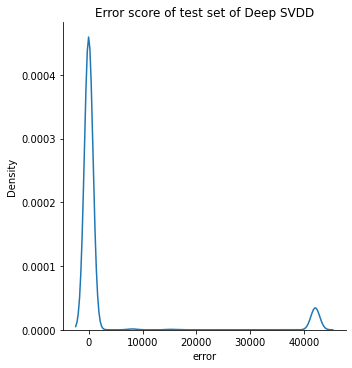

In [26]:
# sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")
plt.title("Error score of test set of Deep SVDD")
plt.show()

In [27]:
threshold= np.percentile(norm_test,92)
threshold

20.552817993164062

In [28]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [29]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [30]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    395298
           1       0.95      0.63      0.76     54621

    accuracy                           0.95    449919
   macro avg       0.95      0.81      0.87    449919
weighted avg       0.95      0.95      0.95    449919



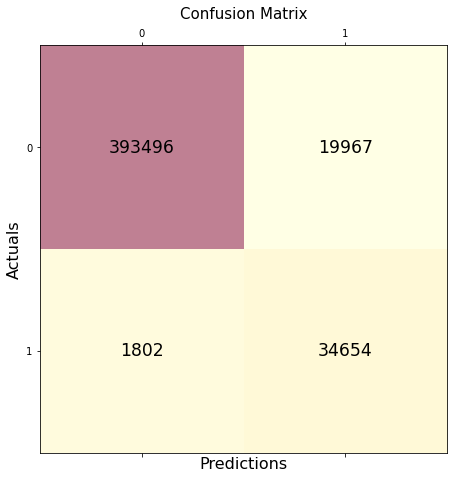

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [32]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [33]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [34]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [35]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [36]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [37]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [38]:
len(start_time) #there are 36 attack

36

In [39]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [40]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'normal/attack')

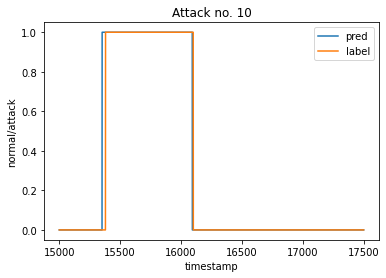

In [41]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 10')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

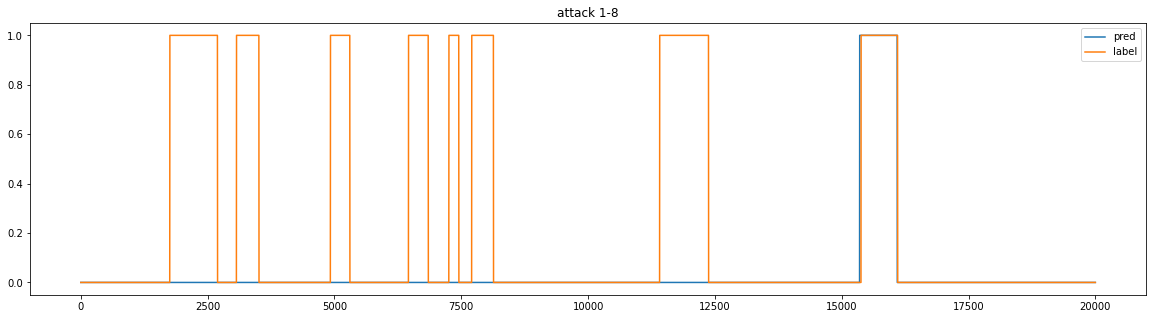

In [42]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

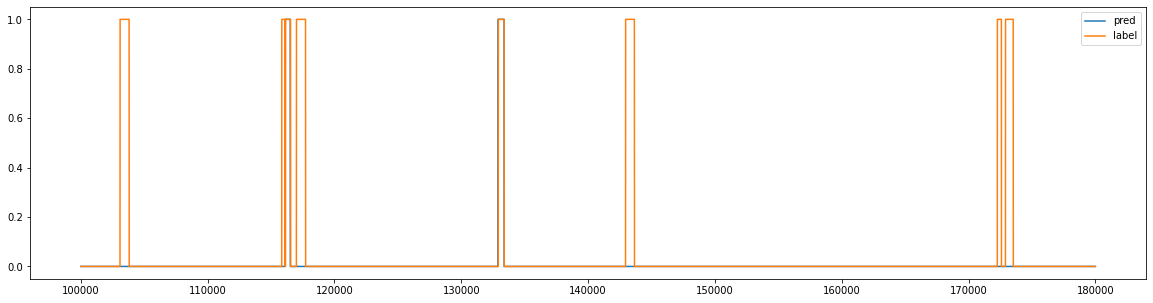

In [43]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

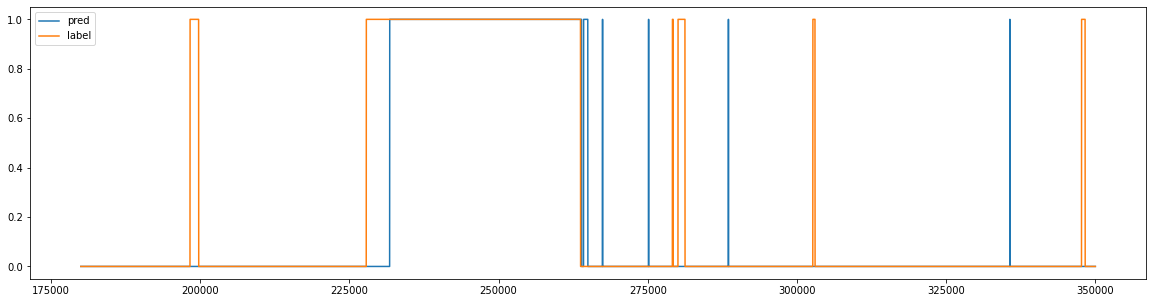

In [44]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

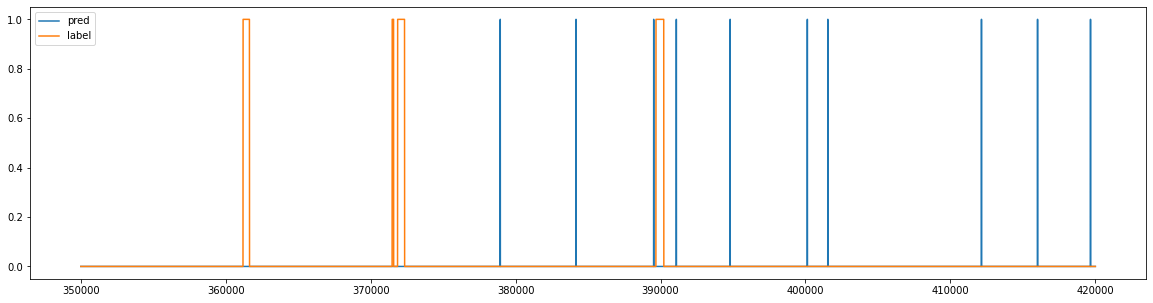

In [45]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

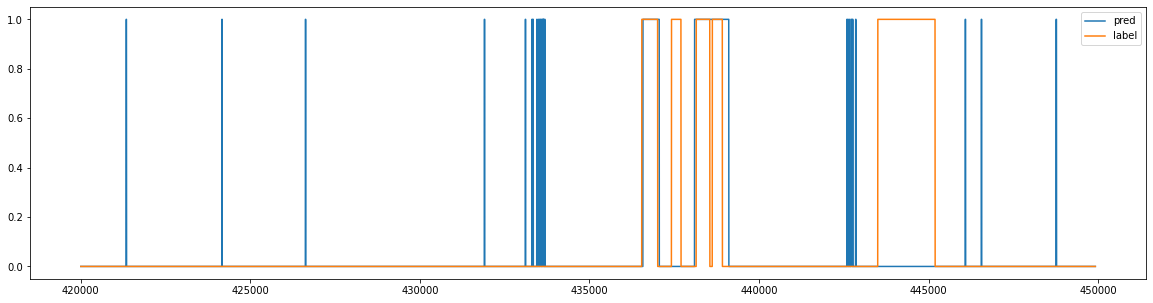

In [46]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

Find attack no. that model found

In [47]:
found = []
for i in range(len(time_label)):
  if (time_label.loc[i]["pred"] == 1) & (time_label.loc[i]["label"] == 1):
    found.append(time_label.loc[i]["attack #"])

In [48]:
np.unique(found)

array([10, 11, 20, 22, 28, 37, 39, 40])

In [49]:
print(f"There are {len(np.unique(found))} attacks found")

There are 8 attacks found


Apply XAI

##CASE STUDY attack no.1
model cannot detect the anomaly point

### SHAP

In [50]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 7.5 MB/s 


In [51]:
import shap

In [52]:
def shap_explanation_attack(data,idx_start,idx_end):
  shap_values = []
  X_train_summary = shap.kmeans(train_scale, 50)
  explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary, link="logit")
  for i in range (len(idx_start)):
    sample = shap.sample(data[idx_start[i]:idx_end[i]], 50)
    shap_values.append(explainer.shap_values(X=sample, nsamples=100))
    # print(shap_values)
    # break
  return shap_values


In [53]:
#summarize all the train data using shap.kmeans
X_train_summary = shap.kmeans(train_scale, 50)

In [54]:
shap_explainer = shap.KernelExplainer(model=model.model_.predict, data=X_train_summary)

In [55]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[0]:idx_end[0]], 100)

In [56]:
np.any(np.isnan(sample)), np.all(np.isfinite(sample))

(False, True)

In [57]:
start = timeit.default_timer()
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)
end = timeit.default_timer()

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [58]:
print(end-start)

44.77533694899989


Single value

In [59]:
sample1 = shap.sample(test_scale[idx_start[0]:idx_end[0]], 1)

In [60]:
start = timeit.default_timer()
shap_value_single = shap_explainer.shap_values(X = sample1, nsamples = 100)
end = timeit.default_timer()

  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [61]:
print(end-start)

0.5120069220001824


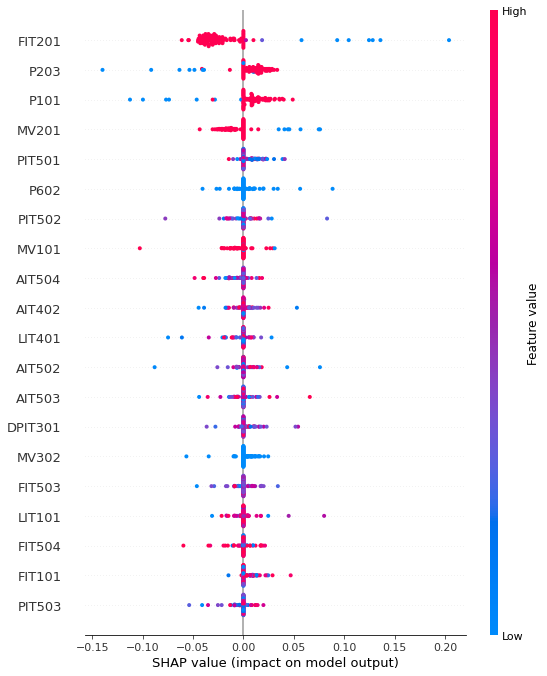

In [62]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

In [63]:
shap_result = pd.DataFrame(np.mean(shap_values_1,axis=0), index= train_scale.columns, columns = ["result"])
shap_result.sort_values(by = ["result"])

result
FIT201  -0.014750
MV201   -0.003863
AIT504  -0.003427
LIT401  -0.002322
MV101   -0.002184
PIT503  -0.001893
FIT501  -0.001391
FIT401  -0.001103
FIT504  -0.000838
P205    -0.000531
AIT202  -0.000317
FIT503  -0.000238
AIT501  -0.000198
FIT301  -0.000183
FIT502  -0.000159
P402     0.000000
P301     0.000000
P403     0.000000
P404     0.000000
UV401    0.000000
P401     0.000000
P501     0.000000
P603     0.000000
P502     0.000000
P206     0.000000
P601     0.000000
P204     0.000000
P102     0.000000
P202     0.000000
P201     0.000000
AIT503   0.000074
AIT203   0.000085
PIT502   0.000103
AIT402   0.000376
AIT201   0.000501
MV301    0.000524
MV303    0.000534
AIT502   0.000540
FIT601   0.000835
LIT101   0.000848
AIT401   0.001025
MV304    0.001036
P302     0.001132
MV302    0.001250
LIT301   0.001726
P602     0.001943
DPIT301  0.002042
FIT101   0.003315
P203     0.005277
PIT501   0.005624
P101     0.005745

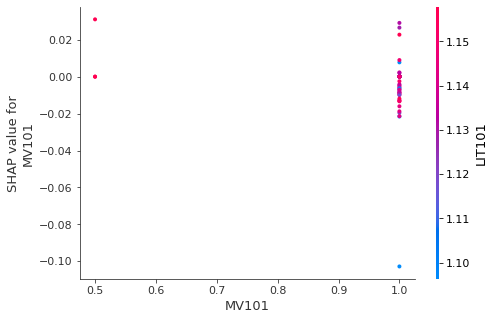

In [64]:
shap.dependence_plot("MV101", shap_values_1, sample)

### LIME

In [65]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 7.1 MB/s 


In [66]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [67]:
lime = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [68]:
def lime_explainer(sample):
  score = []
  n_sample = len(sample)
  for i in (range(n_sample)):
    score.append(lime_explainer.explain_instance(sample.iloc[i], model.decision_function, num_features=51))
  return score

In [69]:
# exp = lime_explainer(sample)

In [70]:
start = timeit.default_timer()
a = lime.explain_instance(sample.iloc[10], model.decision_function, num_features=20)
end = timeit.default_timer()

Intercept 1.4091300774110527
Prediction_local [0.01585065]
Right: 0.025366453


In [71]:
print(end-start)

17.311866582999983


In [72]:
a.show_in_notebook(show_table=False)

In [73]:
start = timeit.default_timer()
sp_obj = submodular_pick.SubmodularPick(lime, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()

Requested sample size larger than
                              size of input data. Using all data


Intercept 1.941231053222464
Prediction_local [0.13850833]
Right: 0.0252546
Intercept 1.415509184755245
Prediction_local [0.08944342]
Right: 0.024925694
Intercept 1.6271668542630953
Prediction_local [0.42394886]
Right: 0.024924375
Intercept 1.4799661876036951
Prediction_local [0.27243484]
Right: 0.025052875
Intercept 1.4059219825103528
Prediction_local [0.06837845]
Right: 0.025341585
Intercept 1.7077906627924384
Prediction_local [0.23013375]
Right: 0.025571425
Intercept 1.7746413791168643
Prediction_local [0.08433822]
Right: 0.025457265
Intercept 1.7853511015897447
Prediction_local [0.18243984]
Right: 0.025254952
Intercept 1.6247111573328612
Prediction_local [0.23571426]
Right: 0.025110587
Intercept 1.4948348534206009
Prediction_local [0.20634632]
Right: 0.025181567
Intercept 1.94672429812607
Prediction_local [0.12511524]
Right: 0.025198085
Intercept 1.6197424680708963
Prediction_local [0.10441123]
Right: 0.025214734
Intercept 1.7498729927620955
Prediction_local [0.10454087]
Right: 0.02

In [74]:
print(end-start)

1384.4258318509999


[<Figure size 432x288 with 1 Axes>]

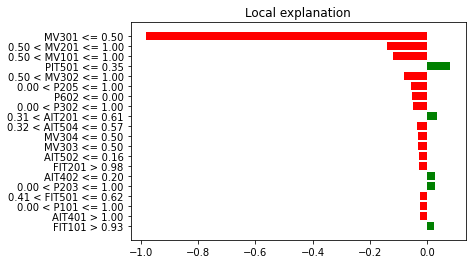

In [75]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

In [76]:
sp_obj.sp_explanations[0].as_list()

[('MV301 <= 0.50', -0.9820442945099755),
 ('0.50 < MV201 <= 1.00', -0.14062973893230157),
 ('0.50 < MV101 <= 1.00', -0.12021037647399448),
 ('PIT501 <= 0.35', 0.0805684419499986),
 ('0.50 < MV302 <= 1.00', -0.08053187616516748),
 ('0.00 < P205 <= 1.00', -0.056320368471189604),
 ('P602 <= 0.00', -0.05474275744537136),
 ('0.00 < P302 <= 1.00', -0.0509428909182761),
 ('0.31 < AIT201 <= 0.61', 0.035346727990717),
 ('0.32 < AIT504 <= 0.57', -0.0340864278373068),
 ('MV304 <= 0.50', -0.0329282680580507),
 ('MV303 <= 0.50', -0.032003247699788184),
 ('AIT502 <= 0.16', -0.029075102197536482),
 ('FIT201 > 0.98', -0.028969987645836207),
 ('AIT402 <= 0.20', 0.027503287832706422),
 ('0.00 < P203 <= 1.00', 0.026550120694104735),
 ('0.41 < FIT501 <= 0.62', -0.0256780889871378),
 ('0.00 < P101 <= 1.00', -0.024130829949930738),
 ('AIT401 > 1.00', -0.02400702549531307),
 ('FIT101 > 0.93', 0.023779271764184814)]

###IntegratedGradients

In [77]:
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 445 kB 7.0 MB/s 
     |████████████████████████████████| 60 kB 8.5 MB/s 
     |████████████████████████████████| 4.7 MB 63.3 MB/s 
     |████████████████████████████████| 98.5 MB 165 kB/s 
     |████████████████████████████████| 596 kB 66.4 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.9 MB/s 


In [78]:
from alibi.explainers import IntegratedGradients
import tensorflow as tf

In [79]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [80]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))
end = timeit.default_timer()

In [81]:
print(end-start)

3.6431432549998135


In [82]:
attributions = ig_explanation.attributions

In [83]:
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])

In [84]:
ig_result.sort_values(by = ["result"], ascending=False)

result
MV201    2.009046
P203     0.857889
P302     0.550776
P101     0.367743
MV301    0.359799
MV302    0.158150
PIT501   0.033766
MV101    0.026228
AIT504   0.024445
FIT501   0.018454
FIT401   0.015643
AIT501   0.010688
FIT504   0.010642
FIT503   0.007672
MV304    0.007514
MV303    0.006227
DPIT301  0.005324
FIT502   0.004070
AIT401   0.003803
P205     0.002497
AIT202   0.001627
AIT201   0.001572
LIT401   0.000643
AIT502   0.000419
AIT203   0.000387
LIT301   0.000317
AIT402   0.000077
UV401    0.000000
P501     0.000000
P502     0.000000
P601     0.000000
P602     0.000000
P603     0.000000
P404     0.000000
P206     0.000000
P102     0.000000
P201     0.000000
P202     0.000000
P403     0.000000
P204     0.000000
P301     0.000000
P401     0.000000
P402     0.000000
FIT601  -0.000047
LIT101  -0.001987
AIT503  -0.002132
PIT502  -0.002229
FIT301  -0.010252
FIT101  -0.010676
PIT503  -0.014216
FIT201  -0.411988

Text(0.5, 0, 'feature')

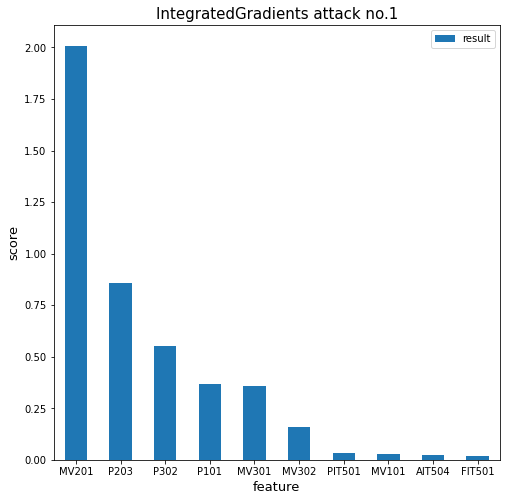

In [85]:
ig_plot = ig_result.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.1",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

single value

In [86]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample1.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample1))
end = timeit.default_timer()

In [87]:
print(end-start)

0.13284791700016285


In [88]:
# type(model).__mro__

##CASE STUDY attack no.10
model can detect the anomaly point

###SHAP

In [89]:
sample_9 = shap.sample(test_scale[idx_start[7]:idx_end[7]], 100)

In [90]:
shap_value_9 = shap_explainer.shap_values(X = sample_9, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

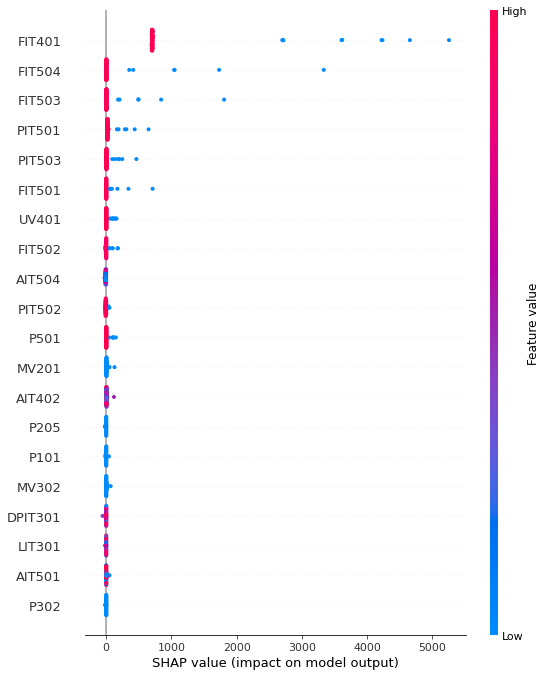

In [91]:
shap.initjs()
shap.summary_plot(shap_value_9, sample_9)

In [92]:
shap_result_9 = pd.DataFrame(np.mean(shap_value_9,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_9.sort_values(by = ["result"])

result
AIT504    -8.697273
PIT502    -4.729078
P205      -3.601296
DPIT301   -3.101445
LIT301    -2.967273
P101      -2.440546
P302      -2.383401
AIT401    -1.974785
AIT502    -1.729827
MV101     -1.561050
LIT401    -1.248309
AIT503    -0.553313
LIT101    -0.372108
FIT201    -0.367754
FIT301    -0.140108
P602      -0.097320
AIT201    -0.023797
MV303     -0.022443
P404       0.000000
P403       0.000000
P601       0.000000
P402       0.000000
P401       0.000000
P502       0.000000
P603       0.000000
P102       0.000000
P206       0.000000
P204       0.000000
P301       0.000000
P202       0.000000
P201       0.000000
AIT202     0.105716
MV304      0.139183
AIT203     0.248600
P203       0.471451
FIT601     0.509168
MV301      0.605421
FIT101     1.530502
AIT501     2.844929
MV302      3.171063
FIT502     3.761908
AIT402     5.869537
MV201      6.011566
P501       6.132133
UV401     10.051511
FIT501    13.628051
PIT503    15.812635
PIT501    37.994230
FIT503    42.218031
FIT504    80.627734
FIT401   978.739621

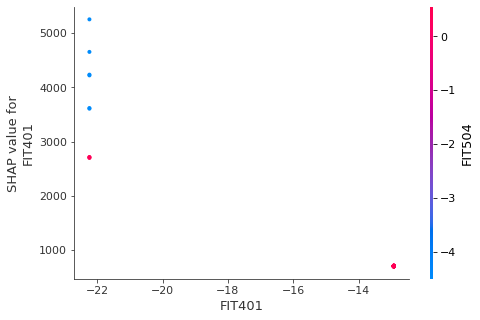

In [93]:
shap.dependence_plot("FIT401", shap_value_9, sample_9)

###LIME

In [94]:
sp_obj_9 = submodular_pick.SubmodularPick(lime, sample_9.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -2.7275588391537022
Prediction_local [13.57671596]
Right: 698.01526
Intercept -15.190195645226705
Prediction_local [55.36177031]
Right: 2849.0447
Intercept -2.465655807342474
Prediction_local [13.93173397]
Right: 698.1221
Intercept -3.6657553602441486
Prediction_local [14.85872495]
Right: 704.0001
Intercept -3.6148688679696512
Prediction_local [14.68400581]
Right: 700.451
Intercept -2.870415593349145
Prediction_local [14.45421985]
Right: 705.4812
Intercept -3.6707302346752644
Prediction_local [14.2067548]
Right: 703.4616
Intercept -2.7244495909143227
Prediction_local [14.209243]
Right: 699.29016
Intercept -2.5948924727958356
Prediction_local [13.43364859]
Right: 705.5668
Intercept -2.502317748683682
Prediction_local [13.57482402]
Right: 705.58936
Intercept -2.161801501248352
Prediction_local [13.37428526]
Right: 704.5697
Intercept -2.601724887012854
Prediction_local [13.66784389]
Right: 697.00903
Intercept -38.664998954707315
Prediction_local [138.4779434]
Right: 6808.917
Int

[<Figure size 432x288 with 1 Axes>]

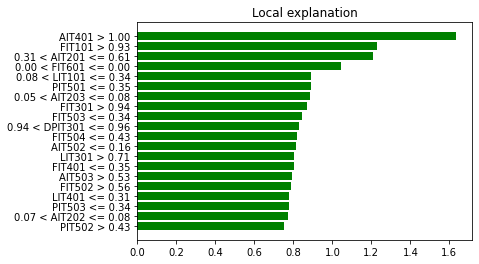

In [95]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj_9.sp_explanations]

In [96]:
sp_obj_9.sp_explanations[0].as_list()

[('AIT401 > 1.00', 1.6357017239119593),
 ('FIT101 > 0.93', 1.2284673943501783),
 ('0.31 < AIT201 <= 0.61', 1.2089309309933358),
 ('0.00 < FIT601 <= 0.00', 1.0456666082181965),
 ('0.08 < LIT101 <= 0.34', 0.8925442467142592),
 ('PIT501 <= 0.35', 0.8885040190913472),
 ('0.05 < AIT203 <= 0.08', 0.8837957665448795),
 ('FIT301 > 0.94', 0.8681818037033635),
 ('FIT503 <= 0.34', 0.845326373803722),
 ('0.94 < DPIT301 <= 0.96', 0.8289044214004825),
 ('FIT504 <= 0.43', 0.8204452456666105),
 ('AIT502 <= 0.16', 0.8156977405659773),
 ('LIT301 > 0.71', 0.8034830581457059),
 ('FIT401 <= 0.35', 0.8030701478706544),
 ('AIT503 > 0.53', 0.7941846566840884),
 ('FIT502 > 0.56', 0.7863373838825171),
 ('LIT401 <= 0.31', 0.7783173604088001),
 ('PIT503 <= 0.34', 0.7782415464700588),
 ('0.07 < AIT202 <= 0.08', 0.7699480487675947),
 ('PIT502 > 0.43', 0.7509305416274936)]

### Intergrate Gredient

In [97]:
ig_explanation_9 = ig.explain(sample_9.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_9))

In [98]:
attributions_9 = ig_explanation_9.attributions

In [99]:
ig_result_9 = pd.DataFrame(np.mean(attributions_9[0],axis=0), index= train_scale.columns, columns = ["result"])

In [100]:
ig_result_9.sort_values(by = ["result"])

result
DPIT301   -28.110999
P302      -25.255053
AIT401    -25.086980
MV101     -23.585965
AIT504    -21.219398
P101      -20.431278
P205      -16.412349
LIT301    -15.585736
MV303     -14.419838
PIT502     -9.862942
FIT301     -9.413414
AIT501     -8.043385
FIT502     -6.930541
AIT503     -6.485698
AIT402     -2.080472
AIT201     -2.032250
AIT203     -0.944810
AIT202     -0.706911
LIT401     -0.280754
FIT201     -0.200973
FIT601     -0.004170
P502        0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P601        0.000000
P603        0.000000
P602        0.000000
P102        0.000000
P201        0.000000
P204        0.000000
P206        0.000000
P202        0.000000
P301        0.000000
LIT101      0.311329
MV304       1.197329
AIT502      1.551255
P203        2.556610
P501        7.885049
UV401       8.309163
FIT501     10.255485
MV301      10.432187
PIT503     11.759465
FIT101     12.843186
PIT501     14.253319
FIT503     31.818711
MV201      41.656384
MV302      48.046557
FIT504     67.706789
FIT401   1136.939957

Text(0.5, 0, 'feature')

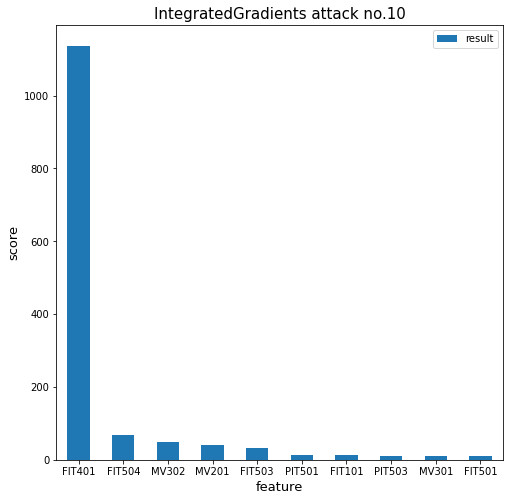

In [101]:
ig_plot_9 = ig_result_9.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot_9.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.10",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

## Attck no. 11


In [104]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 11)].index.values

In [105]:
sample_11 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [106]:
shap_value_11 = shap_explainer.shap_values(X = sample_11, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [107]:
shap_result_11 = pd.DataFrame(np.mean(shap_value_11,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_11.sort_values(by = ["result"])

result
P603        0.000000
P404        0.000000
P204        0.000000
P301        0.000000
P202        0.000000
P201        0.000000
P206        0.000000
P403        0.000000
P502        0.000000
P102        0.000000
P401        0.000000
P601        0.000000
AIT504      0.040222
AIT501      3.141721
AIT402      4.175731
P402        6.250815
AIT202      9.421717
MV201      10.500551
MV101      12.762225
MV301      13.159039
P203       14.653201
P602       14.816993
P101       15.039370
LIT401     15.526183
FIT301     16.711451
AIT401     17.231047
MV302      17.390053
MV303      18.383686
FIT201     18.686128
P205       18.951422
FIT601     19.679770
MV304      19.752974
P302       22.377022
AIT201     22.610099
LIT101     23.031096
DPIT301    24.463282
FIT101     24.601950
AIT203     26.336490
AIT503     27.398054
LIT301     31.664995
PIT502     33.073377
AIT502     65.006844
P501       82.373982
UV401      85.854548
FIT502    161.998183
PIT503    404.500183
PIT501    873.973549
FIT501    901.490135
FIT503   2253.013375
FIT504   4139.775058
FIT401   5082.050133

In [109]:
sp_obj_11 = submodular_pick.SubmodularPick(lime, sample_11.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -84.32157773783979
Prediction_local [303.48217044]
Right: 14945.98
Intercept -84.3766750617514
Prediction_local [305.67529359]
Right: 15526.096
Intercept -88.84591631840041
Prediction_local [318.54077878]
Right: 15531.873
Intercept -80.3068631902779
Prediction_local [299.09829625]
Right: 14885.641
Intercept -84.90829636756247
Prediction_local [543.69184886]
Right: 14535.455
Intercept -84.09454402114432
Prediction_local [297.83450339]
Right: 15492.217
Intercept -86.79412392582753
Prediction_local [303.70052189]
Right: 14904.221
Intercept -83.20996561928425
Prediction_local [295.8207734]
Right: 15032.924
Intercept -84.17189387336946
Prediction_local [307.45692123]
Right: 15152.95
Intercept -83.21023977967181
Prediction_local [288.18949386]
Right: 14944.008
Intercept -82.51179189908719
Prediction_local [295.6060584]
Right: 14948.172
Intercept -83.97638914018181
Prediction_local [312.00752238]
Right: 15211.943
Intercept -80.59122707648213
Prediction_local [285.61488882]
Right: 14

In [110]:
sp_obj_11.sp_explanations[0].as_list()

[('AIT401 > 1.00', 35.3942053973035),
 ('FIT101 > 0.93', 26.611727120166243),
 ('0.31 < AIT201 <= 0.61', 24.67553059916185),
 ('0.00 < FIT601 <= 0.00', 20.579618480512057),
 ('0.08 < AIT202 <= 0.16', 20.326991186575988),
 ('0.08 < LIT101 <= 0.34', 19.306272741866625),
 ('AIT402 > 0.78', 18.04135145968078),
 ('0.05 < AIT203 <= 0.08', 17.90002579976395),
 ('0.01 < FIT201 <= 0.98', 17.554571322704863),
 ('PIT503 <= 0.34', 17.201838495425545),
 ('LIT301 > 0.71', 17.029799206546134),
 ('0.94 < DPIT301 <= 0.96', 17.005166846052703),
 ('FIT401 <= 0.35', 16.805269577465722),
 ('FIT501 <= 0.32', 16.729218889349923),
 ('LIT401 <= 0.31', 16.60413436120165),
 ('FIT502 <= 0.41', 16.123098101963773),
 ('AIT502 > 0.78', 15.990376507072027),
 ('PIT502 <= 0.30', 15.859914331059617),
 ('AIT501 > 0.68', 15.660988680769732),
 ('PIT501 <= 0.35', 15.449255998096755)]

In [111]:
ig_explanation_11 = ig.explain(sample_11.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_11))

In [112]:
attributions_11 = ig_explanation_11.attributions

In [116]:
ig_result_11 = pd.DataFrame(np.mean(attributions_11[0],axis=0), index= train_scale.columns, columns = ["result"])

In [117]:
ig_result_11.sort_values(by = ["result"])

result
AIT402   -226.743779
AIT501   -217.946096
AIT504   -159.238005
P302     -134.630633
P101     -129.354972
AIT401   -121.225625
MV101     -92.101629
DPIT301   -84.072549
LIT301    -74.383190
P205      -72.655654
MV303     -50.628296
FIT301    -38.863282
AIT503    -21.879980
P203      -21.565017
AIT201    -12.612973
FIT601    -10.471916
MV304      -7.352802
AIT203     -5.037920
P602       -4.700678
LIT101     -2.208701
AIT202     -2.096799
LIT401     -1.993881
P502        0.000000
P403        0.000000
P401        0.000000
P601        0.000000
P404        0.000000
P603        0.000000
P301        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
P402       10.154259
MV301      32.794533
PIT502     38.758788
FIT201     39.210119
FIT101     46.018405
UV401     115.549493
MV201     144.887858
AIT502    153.529497
P501      201.029017
MV302     216.712149
FIT502    257.658048
PIT503    538.193498
PIT501    837.542203
FIT501    919.741235
FIT503   1957.854919
FIT504   4291.834903
FIT401   6238.129764

## Attck no. 20


In [118]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 20)].index.values

In [119]:
sample_20 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [120]:
shap_value_20 = shap_explainer.shap_values(X = sample_20, nsamples = 100)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [121]:
shap_result_20 = pd.DataFrame(np.mean(shap_value_20,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_20.sort_values(by = ["result"])

result
FIT101    -14.644228
FIT201    -10.823326
P205       -8.755586
PIT502     -8.230252
FIT503     -6.462891
FIT301     -5.076253
FIT502     -4.644219
P101       -3.988521
PIT501     -3.806984
FIT401     -3.400254
LIT101     -2.403400
AIT401     -1.556808
FIT504     -1.551713
DPIT301    -1.394177
MV201      -1.125898
AIT402     -1.067570
LIT301     -1.054661
FIT601     -0.159323
MV303      -0.076115
MV301      -0.034119
P403        0.000000
P404        0.000000
UV401       0.000000
P502        0.000000
P202        0.000000
P102        0.000000
P601        0.000000
P501        0.000000
P402        0.000000
P603        0.000000
P204        0.000000
P201        0.000000
P206        0.000000
P401        0.000000
P301        0.000000
MV302       0.013963
MV304       0.091878
P602        0.107678
AIT203      0.136011
AIT202      0.151259
LIT401      0.155346
P302        0.221066
AIT501      0.856512
P203        1.324418
PIT503      1.349168
AIT502      3.033400
AIT201      3.573701
MV101       4.264161
FIT501      4.334443
AIT503     10.276554
AIT504   8471.129453

In [122]:
sp_obj_20 = submodular_pick.SubmodularPick(lime, sample_20.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -47.336142710911744
Prediction_local [164.49312229]
Right: 8435.416
Intercept -46.31677655131389
Prediction_local [162.57149122]
Right: 8414.5
Intercept -45.622639975656774
Prediction_local [161.8754668]
Right: 8417.879
Intercept -46.834389498834916
Prediction_local [161.08944552]
Right: 8433.178
Intercept -47.36376743786942
Prediction_local [165.49569461]
Right: 8398.332
Intercept -46.59348902347632
Prediction_local [163.56878957]
Right: 8419.474
Intercept -45.89659035152313
Prediction_local [160.84795295]
Right: 8428.193
Intercept -47.10431410424786
Prediction_local [167.67493842]
Right: 8409.794
Intercept -45.62643798755626
Prediction_local [160.80860481]
Right: 8441.693
Intercept -46.57452082128266
Prediction_local [167.36682284]
Right: 8412.729
Intercept -44.704071563346005
Prediction_local [152.92485935]
Right: 8426.379
Intercept -47.99088549020047
Prediction_local [170.33596755]
Right: 8421.98
Intercept -47.689110650533856
Prediction_local [170.08296727]
Right: 8406.06

In [123]:
sp_obj_20.sp_explanations[0].as_list()

[('AIT401 > 1.00', 20.64029840172065),
 ('FIT101 > 0.93', 15.116296901079071),
 ('0.00 < FIT601 <= 0.00', 11.790110198383392),
 ('PIT501 <= 0.35', 10.501051797237901),
 ('PIT502 > 0.43', 9.987631975173773),
 ('0.08 < AIT202 <= 0.16', 9.71544597652099),
 ('0.31 < LIT401 <= 0.52', 9.646023245966132),
 ('FIT504 <= 0.43', 9.471407078827067),
 ('FIT503 <= 0.34', 9.328051411697084),
 ('AIT503 <= 0.42', 9.326172262997737),
 ('0.94 < DPIT301 <= 0.96', 9.317957927766654),
 ('AIT502 <= 0.16', 9.304622983926745),
 ('PIT503 <= 0.34', 9.291055957965717),
 ('AIT504 > 0.57', 9.21058461815762),
 ('FIT502 > 0.56', 9.14750630246512),
 ('LIT101 <= 0.08', 9.140401264734974),
 ('0.94 < FIT301 <= 0.94', 9.086050679101223),
 ('0.08 < AIT203 <= 0.10', 8.778128790111078),
 ('0.54 < LIT301 <= 0.71', 8.774476001687695),
 ('FIT501 > 0.62', 8.466835624495145)]

In [124]:
ig_explanation_20 = ig.explain(sample_20.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_20))

In [125]:
attributions_20 = ig_explanation_20.attributions

In [126]:
ig_result_20 = pd.DataFrame(np.mean(attributions_20[0],axis=0), index= train_scale.columns, columns = ["result"])

In [127]:
ig_result_20.sort_values(by = ["result"])

result
FIT101    -56.710031
FIT201    -51.066426
FIT301    -39.470625
P205      -33.794924
FIT502    -30.636331
AIT503    -22.331558
PIT502    -20.460692
LIT301    -19.517087
FIT401    -19.492086
MV201     -19.401302
P101      -19.032182
MV301     -18.289383
AIT401    -18.229001
MV303     -15.598761
DPIT301   -10.531931
PIT503     -4.319511
AIT502     -2.020317
AIT203     -1.367624
AIT501     -0.748155
AIT202     -0.621751
LIT401     -0.017094
FIT601     -0.002592
P404        0.000000
UV401       0.000000
P204        0.000000
P501        0.000000
P502        0.000000
P601        0.000000
P102        0.000000
P402        0.000000
P403        0.000000
P603        0.000000
P602        0.000000
P301        0.000000
P202        0.000000
P206        0.000000
P201        0.000000
P401        0.000000
AIT402      0.062235
MV304       0.707335
AIT201      0.926498
LIT101      1.233621
MV302       7.266675
FIT504      8.317768
PIT501      9.768314
P302       14.182804
FIT503     15.660360
P203       18.920506
FIT501     27.526001
MV101      48.494129
AIT504   8667.322914

## Attck no. 22


In [128]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 22)].index.values

In [129]:
sample_22 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [130]:
shap_value_22 = shap_explainer.shap_values(X = sample_22, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [131]:
shap_result_22 = pd.DataFrame(np.mean(shap_value_22,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_22.sort_values(by = ["result"])

result
AIT504    -80.242804
AIT402     -6.866303
AIT501     -4.848590
P603        0.000000
P204        0.000000
P401        0.000000
P202        0.000000
P201        0.000000
P402        0.000000
P403        0.000000
P404        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
P206        0.000000
P301        0.000000
LIT101      3.539213
FIT101      5.245430
MV304       5.463756
AIT401      6.582204
AIT201      8.509411
P205        8.870891
AIT202      9.109691
AIT503      9.296982
P302        9.347180
MV303      10.683321
AIT502     12.143393
P602       12.385652
LIT301     12.509993
DPIT301    12.639090
P101       13.081927
MV201      14.749247
MV301      14.866042
FIT601     14.912818
MV302      16.170391
LIT401     16.194861
P203       17.532684
FIT201     17.932362
AIT203     18.369627
FIT301     19.917089
MV101      20.058824
PIT502     20.618433
P501       30.773769
FIT502     35.584150
UV401     113.518311
PIT503    129.699820
PIT501    729.272126
FIT401    732.803365
FIT501    969.394894
FIT503   2090.458514
FIT504   3015.228007

In [132]:
sp_obj_22 = submodular_pick.SubmodularPick(lime, sample_22.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -49.27308637621564
Prediction_local [149.67332045]
Right: 8936.709
Intercept -42.952385589839615
Prediction_local [134.40275368]
Right: 7999.3574
Intercept -43.425725209205396
Prediction_local [134.11954484]
Right: 7990.4844
Intercept -44.18399002628488
Prediction_local [138.11802731]
Right: 8014.11
Intercept -42.848615779879566
Prediction_local [132.32165589]
Right: 8026.4307
Intercept -48.54262021112906
Prediction_local [147.22574256]
Right: 8874.648
Intercept -44.462808263990944
Prediction_local [137.98747409]
Right: 8054.2954
Intercept -43.60132424517295
Prediction_local [133.49733065]
Right: 8044.2134
Intercept -44.2211043942311
Prediction_local [137.18559518]
Right: 8002.299
Intercept -43.76353389907409
Prediction_local [137.63442825]
Right: 7981.3706
Intercept -44.18246308975347
Prediction_local [137.71708629]
Right: 7976.476
Intercept -46.44196074267661
Prediction_local [144.54799917]
Right: 8633.184
Intercept -43.10381920060488
Prediction_local [135.44436575]
Right: 

In [133]:
sp_obj_22.sp_explanations[0].as_list()

[('AIT402 > 0.78', 10.340828970553105),
 ('LIT101 > 0.64', 10.101162095133068),
 ('PIT501 <= 0.35', 9.662772548369425),
 ('AIT503 <= 0.42', 9.638255856685026),
 ('DPIT301 > 0.96', 9.441256085848567),
 ('0.16 < AIT502 <= 0.50', 9.428356999985299),
 ('AIT202 > 0.16', 9.328561272352868),
 ('0.08 < AIT203 <= 0.10', 9.319093064763624),
 ('AIT501 > 0.68', 9.303004723259221),
 ('LIT301 <= 0.36', 9.023976326987562),
 ('FIT201 > 0.98', 8.862950147473654),
 ('0.12 < FIT301 <= 0.94', 8.777300802004284),
 ('FIT501 <= 0.32', 8.675108897178745),
 ('FIT503 <= 0.34', 8.596593346050392),
 ('FIT502 <= 0.41', 8.561802227263243),
 ('PIT502 <= 0.30', 8.535275127216659),
 ('FIT504 <= 0.43', 8.498157955508038),
 ('PIT503 <= 0.34', 8.371282376727402),
 ('FIT401 <= 0.35', 8.313147278065742),
 ('AIT504 > 0.57', 8.203663258493895)]

In [134]:
ig_explanation_22 = ig.explain(sample_22.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_22))

In [135]:
attributions_22 = ig_explanation_22.attributions

In [136]:
ig_result_22 = pd.DataFrame(np.mean(attributions_22[0],axis=0), index= train_scale.columns, columns = ["result"])

In [137]:
ig_result_22.sort_values(by = ["result"])

result
AIT504   -283.025738
AIT402   -191.723916
AIT501   -153.643089
AIT401   -116.101261
P101     -111.059385
P302      -96.622948
MV101     -59.255992
P205      -57.224279
DPIT301   -53.151246
LIT101    -26.082101
MV304     -25.978235
FIT301    -17.171244
AIT201    -12.760726
LIT401     -9.698273
AIT203     -9.138317
MV303      -9.104947
LIT301     -3.852045
FIT601      0.000000
P401        0.000000
P602        0.000000
P404        0.000000
P601        0.000000
P502        0.000000
P402        0.000000
P403        0.000000
FIT101      0.000000
P603        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
P301        0.000000
AIT202      0.840095
AIT503      5.332750
P203        7.064990
PIT502     21.723700
AIT502     22.541595
FIT502     24.373733
P501       41.214780
FIT201     44.818884
MV301      64.632113
MV302     116.508184
PIT503    142.077721
MV201     146.031665
UV401     155.644551
PIT501    758.631467
FIT401    814.914896
FIT501    986.033093
FIT503   2884.235391
FIT504   3080.447023

## Attck no. 28


In [138]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 28)].index.values

In [139]:
sample_28 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [140]:
shap_value_28 = shap_explainer.shap_values(X = sample_28, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [141]:
shap_result_28 = pd.DataFrame(np.mean(shap_value_28,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_28.sort_values(by = ["result"])

result
AIT504     -0.220571
P603        0.000000
P601        0.000000
P502        0.000000
P102        0.000000
P404        0.000000
P403        0.000000
P401        0.000000
P301        0.000000
P201        0.000000
P202        0.000000
P204        0.000000
P206        0.000000
AIT402     10.338036
MV302      32.715273
AIT401     32.936665
LIT101     33.759293
FIT101     39.995675
LIT301     41.635727
AIT503     44.791557
P203       45.616417
AIT201     52.046300
P602       53.217797
FIT201     53.412262
MV301      53.757863
MV304      54.402757
FIT301     69.348838
MV201      72.109572
AIT202     72.738373
DPIT301    76.776204
AIT203     77.800656
FIT601     79.852422
MV303      84.913145
MV101      86.207190
P302       95.757741
PIT502     98.433737
P501      103.663669
LIT401    124.173240
P101      126.027984
P205      132.858575
AIT502    143.651978
UV401     243.621287
P402      273.625617
AIT501    361.309585
FIT502    379.746844
PIT503   1321.171257
PIT501   5484.349065
FIT401   6619.530240
FIT504   7109.549697
FIT501   8518.350818
FIT503   9533.493399

In [142]:
sp_obj_28 = submodular_pick.SubmodularPick(lime, sample_28.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -243.65206060451527
Prediction_local [988.6495101]
Right: 42437.023
Intercept -241.11199386178862
Prediction_local [1014.25069712]
Right: 41779.56
Intercept -238.19219148722325
Prediction_local [974.60341454]
Right: 42445.676
Intercept -240.78528254530545
Prediction_local [1027.56117915]
Right: 41686.484
Intercept -250.1770464176558
Prediction_local [1082.36355944]
Right: 41791.125
Intercept -242.6940013291389
Prediction_local [1020.1112622]
Right: 41928.15
Intercept -245.12629335007247
Prediction_local [1049.70491779]
Right: 41702.89
Intercept -242.13259396214872
Prediction_local [1079.860558]
Right: 41711.45
Intercept -251.1433422683092
Prediction_local [1097.04886462]
Right: 41855.047
Intercept -237.3144726514859
Prediction_local [988.22280075]
Right: 42213.32
Intercept -240.5093554899887
Prediction_local [1039.08854538]
Right: 41790.75
Intercept -245.30537624538576
Prediction_local [1066.9945531]
Right: 41712.684
Intercept -236.35482930586807
Prediction_local [949.4989564

In [143]:
sp_obj_28.sp_explanations[0].as_list()

[('MV304 > 0.50', 342.1291448707308),
 ('AIT401 > 1.00', 95.83761723520716),
 ('AIT402 > 0.78', 55.457142248171486),
 ('PIT501 <= 0.35', 52.395819301704),
 ('FIT301 <= 0.12', 52.14310670378071),
 ('LIT301 > 0.71', 51.472559659388686),
 ('0.49 < AIT503 <= 0.53', 50.5587123032719),
 ('FIT503 <= 0.34', 49.88774407433861),
 ('FIT401 <= 0.35', 49.58202684428316),
 ('AIT202 > 0.16', 48.972797423907785),
 ('AIT502 > 0.78', 48.91831199921106),
 ('AIT504 > 0.57', 48.26830396108054),
 ('DPIT301 <= 0.12', 47.89369232234705),
 ('FIT501 <= 0.32', 47.66698914329968),
 ('PIT503 <= 0.34', 45.917508503378876),
 ('LIT101 > 0.64', 45.46669873424124),
 ('FIT502 <= 0.41', 45.446140734995126),
 ('FIT201 <= 0.01', 45.13016648214828),
 ('PIT502 <= 0.30', 44.64524357239319),
 ('FIT504 <= 0.43', 43.914175165258214)]

In [144]:
ig_explanation_28 = ig.explain(sample_28.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_28))

In [145]:
attributions_28 = ig_explanation_28.attributions

In [146]:
ig_result_28 = pd.DataFrame(np.mean(attributions_28[0],axis=0), index= train_scale.columns, columns = ["result"])

In [147]:
ig_result_28.sort_values(by = ["result"])

result
AIT402    -945.317132
AIT504    -656.263375
AIT401    -267.389238
MV101     -125.414650
MV304     -122.928114
LIT301    -111.423020
LIT101    -105.274474
AIT201    -102.948438
AIT203     -38.021084
MV303      -21.502823
DPIT301    -12.960179
AIT202      -0.531160
FIT601      -0.000818
FIT301      -0.000051
P403         0.000000
P401         0.000000
P602         0.000000
P302         0.000000
P601         0.000000
P301         0.000000
P502         0.000000
P404         0.000000
FIT101       0.000000
P603         0.000000
P206         0.000000
P205         0.000000
P204         0.000000
P101         0.000000
P102         0.000000
P203         0.000000
FIT201       0.000000
P202         0.000000
P201         0.000000
AIT503      20.333130
PIT502      51.371167
P501       115.484755
MV302      134.177769
MV301      146.487233
LIT401     150.844226
MV201      178.420703
FIT502     240.246290
P402       309.323933
UV401      368.852193
AIT502     388.896941
AIT501     450.534522
PIT503    1154.244292
PIT501    5407.342309
FIT504    6724.943816
FIT401    6875.487209
FIT501    8811.417738
FIT503   12814.999425

## Attck no. 37


In [148]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 37)].index.values

In [149]:
sample_37 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [150]:
shap_value_37 = shap_explainer.shap_values(X = sample_37, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [151]:
shap_result_37 = pd.DataFrame(np.mean(shap_value_37,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_37.sort_values(by = ["result"])

result
AIT504   -151.260297
P603        0.000000
P601        0.000000
P502        0.000000
P501        0.000000
P102        0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P201        0.000000
P202        0.000000
P401        0.000000
P204        0.000000
P301        0.000000
P206        0.000000
AIT401      2.547868
AIT502      3.872213
AIT201      4.813017
FIT101      6.455684
MV304       7.008479
FIT301      7.612015
MV201       7.703443
P205        8.557190
AIT503      9.452342
LIT401      9.775413
MV301       9.938697
FIT601      9.951974
LIT101     10.644946
DPIT301    10.834204
FIT201     11.148143
P302       12.716529
MV302      13.220576
P203       13.500279
AIT203     13.723178
MV303      14.561269
AIT202     14.712377
FIT502     14.935749
P602       18.522525
LIT301     19.109700
MV101      20.097604
PIT502     21.590269
P101       24.701786
AIT402     37.412907
AIT501     58.167341
PIT503     98.231147
FIT401    666.375750
PIT501    679.526834
FIT501    856.011376
FIT503   2015.403108
FIT504   2987.555701

In [152]:
sp_obj_37 = submodular_pick.SubmodularPick(lime, sample_37.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -40.747459538793485
Prediction_local [122.85135402]
Right: 7399.8105
Intercept -41.323653120566725
Prediction_local [123.65161915]
Right: 7616.632
Intercept -41.85793012739127
Prediction_local [127.42641564]
Right: 7623.591
Intercept -39.31900535343555
Prediction_local [121.07526625]
Right: 7328.5283
Intercept -43.920298089830005
Prediction_local [133.09131944]
Right: 7876.9487
Intercept -39.80862010299588
Prediction_local [121.35939679]
Right: 7393.795
Intercept -41.8058116023041
Prediction_local [132.67847057]
Right: 7698.7676
Intercept -41.10992485497366
Prediction_local [135.70929782]
Right: 7532.5693
Intercept -43.09544491084135
Prediction_local [128.57573523]
Right: 8092.118
Intercept -39.86470002887855
Prediction_local [126.55868203]
Right: 7344.6377
Intercept -41.03776696470905
Prediction_local [128.97855735]
Right: 7478.677
Intercept -43.4626918288945
Prediction_local [136.06564455]
Right: 7928.9453
Intercept -40.51445302624618
Prediction_local [121.86375984]
Right: 

In [153]:
sp_obj_37.sp_explanations[0].as_list()

[('LIT401 > 0.65', 9.836771962009987),
 ('FIT502 > 0.56', 9.523689155297056),
 ('0.12 < FIT301 <= 0.94', 9.239061172758054),
 ('AIT402 <= 0.20', 8.941593678375629),
 ('FIT201 > 0.98', 8.757747892879651),
 ('DPIT301 > 0.96', 8.704155824057972),
 ('AIT502 <= 0.16', 8.636782608286426),
 ('AIT503 <= 0.42', 8.422283434664344),
 ('AIT504 > 0.57', 8.376479639484282),
 ('PIT501 <= 0.35', 8.312340839311725),
 ('PIT503 <= 0.34', 8.17651944354517),
 ('LIT301 <= 0.36', 8.140827272458148),
 ('LIT101 > 0.64', 7.953936946305674),
 ('AIT202 > 0.16', 7.9472699420392034),
 ('FIT503 <= 0.34', 7.65089087852527),
 ('FIT504 <= 0.43', 7.557589432303249),
 ('AIT203 <= 0.05', 7.442732782658868),
 ('FIT401 <= 0.35', 7.436777238880494),
 ('FIT501 <= 0.32', 7.401006641644137),
 ('PIT502 <= 0.30', 7.382001133181752)]

In [154]:
ig_explanation_37 = ig.explain(sample_37.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_37))

In [155]:
attributions_37 = ig_explanation_37.attributions

In [156]:
ig_result_37 = pd.DataFrame(np.mean(attributions_37[0],axis=0), index= train_scale.columns, columns = ["result"])

In [157]:
ig_result_37.sort_values(by = ["result"])

result
AIT504   -396.756975
AIT401   -111.874039
MV101     -76.106579
P302      -75.209955
AIT201    -67.288567
P101      -59.709199
DPIT301   -43.692928
LIT101    -33.287647
P205      -30.600811
LIT401    -25.390120
MV304     -25.322211
AIT502    -18.804643
FIT301    -12.845295
MV303     -10.458065
LIT301     -6.455179
P401        0.000000
P601        0.000000
P403        0.000000
P602        0.000000
UV401       0.000000
P501        0.000000
P502        0.000000
FIT601      0.000000
P402        0.000000
P404        0.000000
P603        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
P301        0.000000
FIT502      0.942069
AIT202      2.598211
P203        3.155024
AIT203      4.525186
AIT503      4.805425
PIT502     20.898687
FIT101     21.057392
FIT201     25.509146
AIT402     30.816276
AIT501     56.329199
MV301      62.213786
MV302      99.819561
MV201     107.924474
PIT503    122.632051
PIT501    666.043221
FIT401    718.019238
FIT501    880.946827
FIT503   2785.636627
FIT504   2945.028221

## Attck no. 39


In [158]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 39)].index.values

In [159]:
sample_39 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [160]:
shap_value_39 = shap_explainer.shap_values(X = sample_39, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [161]:
shap_result_39 = pd.DataFrame(np.mean(shap_value_39,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_39.sort_values(by = ["result"])

result
AIT504     -5.349633
AIT401     -0.227375
P205       -0.215831
AIT502     -0.109335
P101       -0.011878
P601        0.000000
P502        0.000000
P501        0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P301        0.000000
P206        0.000000
P603        0.000000
P204        0.000000
P202        0.000000
P102        0.000000
AIT202      0.015196
P302        0.018410
DPIT301     0.085134
MV101       0.145701
LIT101      0.158281
LIT401      0.166925
FIT301      0.205338
FIT502      0.207163
MV301       0.256618
FIT504      0.300835
MV304       0.366371
FIT501      0.373302
P602        0.413980
P203        0.519776
FIT601      0.638634
FIT101      0.667537
MV303       0.750824
MV302       1.118215
FIT201      1.144346
AIT203      1.228659
PIT502      1.371204
MV201       2.394402
FIT503      2.447019
AIT503      2.799485
LIT301      6.495632
PIT501      9.837652
PIT503     10.049395
AIT402     12.174679
AIT501     21.189327
AIT201     27.509833
P201       98.961699
FIT401   1216.747096

In [162]:
sp_obj_39 = submodular_pick.SubmodularPick(lime, sample_39.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -2.5714657105848966
Prediction_local [756.2146943]
Right: 1504.1342
Intercept -2.7085562046846023
Prediction_local [761.74264673]
Right: 1515.3364
Intercept -1.9881119609403224
Prediction_local [760.03461013]
Right: 1513.7778
Intercept -2.6298856732792024
Prediction_local [754.79350732]
Right: 1502.1135
Intercept -2.608377350323599
Prediction_local [755.52366069]
Right: 1503.9299
Intercept -2.3105815896170045
Prediction_local [755.50115399]
Right: 1503.3813
Intercept -2.648187948310434
Prediction_local [748.2352448]
Right: 1489.259
Intercept -2.7930358489609253
Prediction_local [753.77696042]
Right: 1499.8597
Intercept -2.2820812013344867
Prediction_local [760.16926191]
Right: 1513.0382
Intercept -2.4980350944489462
Prediction_local [764.12579353]
Right: 1521.2766
Intercept -2.426281459129865
Prediction_local [752.69415295]
Right: 1498.98
Intercept -2.465508915611025
Prediction_local [746.64734406]
Right: 1485.741
Intercept -2.351212901717827
Prediction_local [758.44508258]
R

In [163]:
sp_obj_39.sp_explanations[0].as_list()

[('P201 > 0.00', 759.4646658780515),
 ('FIT101 > 0.93', 1.3503341713895964),
 ('PIT501 <= 0.35', 0.9252877996841613),
 ('AIT502 <= 0.16', 0.91150507049232),
 ('PIT503 <= 0.34', 0.8974683946436849),
 ('PIT502 <= 0.30', 0.8931137776920466),
 ('FIT503 <= 0.34', 0.8882641055824544),
 ('LIT301 <= 0.36', 0.8792981764930292),
 ('AIT203 <= 0.05', 0.843051495338693),
 ('FIT401 <= 0.35', 0.8420424207445801),
 ('AIT402 <= 0.20', 0.7863942315905679),
 ('0.43 < FIT504 <= 0.60', 0.7637502421413647),
 ('AIT501 <= 0.40', 0.7506501461356484),
 ('MV301 <= 0.50', -0.5877763120032523),
 ('0.00 < P205 <= 1.00', 0.3795981664709043),
 ('0.00 < P101 <= 1.00', 0.3647606014860865),
 ('0.50 < MV302 <= 1.00', 0.31049154787828276),
 ('0.50 < MV201 <= 1.00', 0.21767564563719943),
 ('0.50 < MV101 <= 1.00', 0.16853377482465812),
 ('P602 <= 0.00', 0.058608025952711085)]

In [164]:
ig_explanation_39 = ig.explain(sample_39.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_39))

In [165]:
attributions_39 = ig_explanation_39.attributions

In [166]:
ig_result_39 = pd.DataFrame(np.mean(attributions_39[0],axis=0), index= train_scale.columns, columns = ["result"])

In [167]:
ig_result_39.sort_values(by = ["result"])

result
P302      -36.238466
P101      -35.207746
DPIT301   -33.166618
AIT504    -32.989093
AIT401    -30.524096
FIT504    -24.784197
P205      -23.817422
MV303     -17.919476
FIT502    -17.384410
MV101     -15.650476
FIT501    -13.570785
FIT503     -8.696449
PIT501     -6.694285
FIT301     -6.135354
P203       -2.981964
PIT503     -2.969112
PIT502     -2.920066
AIT202     -2.828690
LIT301     -2.105616
MV304      -1.362568
AIT502     -1.155276
P403        0.000000
P501        0.000000
P502        0.000000
P601        0.000000
UV401       0.000000
P404        0.000000
FIT601      0.000000
P402        0.000000
P603        0.000000
P204        0.000000
P102        0.000000
P602        0.000000
P301        0.000000
P202        0.000000
P401        0.000000
P206        0.000000
LIT101      0.091148
AIT203      0.714789
LIT401      0.811442
AIT503      1.755776
AIT402      6.016281
FIT101      8.025258
MV301       8.247183
AIT501     11.811532
FIT201     17.054527
AIT201     36.100947
MV201      53.234380
MV302      53.807038
P201      108.889992
FIT401   1423.353525

## Attck no. 40


In [168]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 40)].index.values

In [169]:
sample_40 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [170]:
shap_value_40 = shap_explainer.shap_values(X = sample_40, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [171]:
shap_result_40 = pd.DataFrame(np.mean(shap_value_40,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_40.sort_values(by = ["result"])

result
AIT504     -0.273752
P603        0.000000
P601        0.000000
P502        0.000000
P102        0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P301        0.000000
P202        0.000000
P206        0.000000
P204        0.000000
P101        1.973164
AIT401      6.181352
DPIT301     6.586298
MV303       6.586705
LIT401      7.233985
P602        8.492638
P302        9.847719
P203       10.213352
FIT301     11.015244
AIT202     11.329772
P205       12.041209
AIT203     13.015288
AIT503     13.846826
MV101      14.086616
FIT101     14.402447
FIT601     14.410362
MV301      15.142571
AIT402     15.249594
MV302      16.666943
LIT101     16.684879
MV201      18.009915
AIT502     18.221619
FIT201     19.176709
MV304      21.047839
AIT501     21.313661
PIT502     22.784107
LIT301     26.153700
AIT201     45.809887
UV401      97.209021
P501      111.120770
FIT502    212.045002
P201      306.006093
PIT503    479.018063
PIT501    832.564091
FIT501    921.189697
FIT503   2086.019240
FIT504   3926.559367
FIT401   5083.055962

In [172]:
sp_obj_40 = submodular_pick.SubmodularPick(lime, sample_40.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -45.10290358049921
Prediction_local [8604.69976793]
Right: 17074.842
Intercept -41.55386272450768
Prediction_local [8021.20365019]
Right: 15915.461
Intercept -42.240758528731995
Prediction_local [8161.10664647]
Right: 16199.903
Intercept -44.479221737716955
Prediction_local [8593.25863702]
Right: 17062.512
Intercept 1.6990927975045826
Prediction_local [10.34676178]
Right: 20.375835
Intercept -42.305813119392084
Prediction_local [8062.58425693]
Right: 15993.17
Intercept 1.3947608567605676
Prediction_local [10.34895714]
Right: 20.421814
Intercept -44.00850450357246
Prediction_local [8610.06531228]
Right: 17092.445
Intercept -42.28365337791058
Prediction_local [8162.74496555]
Right: 16194.541
Intercept -40.24994911251526
Prediction_local [8019.61972722]
Right: 15918.653
Intercept -39.77250628566547
Prediction_local [8026.91175803]
Right: 15926.42
Intercept -45.774992508539945
Prediction_local [8605.68820279]
Right: 17074.842
Intercept -41.305951130816936
Prediction_local [8164.3

In [173]:
sp_obj_40.sp_explanations[0].as_list()

[('P201 > 0.00', 8100.029484668315),
 ('FIT101 > 0.93', 13.80045581496095),
 ('FIT401 <= 0.35', 10.194512254215818),
 ('DPIT301 > 0.96', 10.116458450510844),
 ('0.31 < LIT401 <= 0.52', 10.01337694583201),
 ('0.12 < FIT301 <= 0.94', 9.761748533318512),
 ('AIT503 <= 0.42', 9.614760919895298),
 ('AIT202 > 0.16', 9.46788623116366),
 ('LIT301 <= 0.36', 9.427101613961263),
 ('LIT101 <= 0.08', 9.331626099585772),
 ('FIT502 <= 0.41', 9.187414680452026),
 ('FIT504 <= 0.43', 8.98278264136331),
 ('PIT502 <= 0.30', 8.963671610685935),
 ('FIT501 <= 0.32', 8.83536969884311),
 ('PIT501 <= 0.35', 8.788948088893905),
 ('AIT501 > 0.68', 8.69227072806343),
 ('PIT503 <= 0.34', 8.654733832115268),
 ('AIT203 <= 0.05', 8.551664995013523),
 ('FIT503 <= 0.34', 8.02755626872732),
 ('MV301 <= 0.50', 3.797017003218038)]

In [174]:
ig_explanation_40 = ig.explain(sample_40.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_40))

In [175]:
attributions_40 = ig_explanation_40.attributions

In [176]:
ig_result_40 = pd.DataFrame(np.mean(attributions_40[0],axis=0), index= train_scale.columns, columns = ["result"])

In [177]:
ig_result_40.sort_values(by = ["result"])

result
AIT504   -214.831053
P302     -135.997646
P101     -127.317760
AIT401   -115.445367
AIT501    -96.976982
DPIT301   -88.317997
MV101     -86.238211
P205      -72.574639
AIT402    -51.643438
MV303     -48.095009
FIT301    -38.915583
P203      -21.977192
LIT301    -15.799736
AIT202    -10.983793
MV304      -5.942423
LIT401     -5.607134
LIT101     -0.554715
P602        0.000000
P402        0.000000
P404        0.000000
P401        0.000000
P502        0.000000
FIT601      0.000000
P403        0.000000
P601        0.000000
P603        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P301        0.000000
AIT203      2.570618
AIT503      5.963229
MV301      29.404259
PIT502     36.670252
AIT502     38.796124
FIT201     40.196877
FIT101     42.478043
AIT201    108.223435
UV401     108.289305
MV201     142.431043
P501      194.924197
MV302     214.079782
FIT502    258.873119
P201      329.645124
PIT503    505.933638
PIT501    765.408216
FIT501    878.635809
FIT503   1777.834791
FIT504   3986.137874
FIT401   6138.728509